In [66]:
# Necessary libraries

import os
import io
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)
sns.set(style='whitegrid')

### **EXPLORATORY DATA ANALYSIS (EDA)**

In [67]:
# ----- 1. Import training and test csv files as data set -----

df = pd.read_csv('./customer_churn.csv')
df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [68]:
# ----- 2. Quick summary of the dataset -----

print("--- Dataset Shape ---")
print(df.shape)

print("\n--- General Information ---")
print(df.info())

print("\n--- Numerical Description ---")
print(df.describe(include='all'))

--- Dataset Shape ---
(505207, 12)

--- General Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB
None

--- Numerical Description ---
           CustomerID            Age  Gender      

In [69]:
# ----- 3. Initial Data Cleaning -----

# Check duplicates
dups = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {dups}")

if dups > 0:
    print("Duplicate rows are being deleted...")
    df.drop_duplicates(inplace=True)
    print(f"Remaining number of rows: {len(df)}")
else:
    print("No duplicate rows found.")

# Missing data
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_percent}).sort_values('missing_pct', ascending=False)
print("\n--- Missing Data Summary ---")
print(missing_df[missing_df['missing_count'] > 0])


Number of duplicate rows: 0
No duplicate rows found.

--- Missing Data Summary ---
                   missing_count  missing_pct
CustomerID                     1     0.000198
Age                            1     0.000198
Gender                         1     0.000198
Tenure                         1     0.000198
Usage Frequency                1     0.000198
Support Calls                  1     0.000198
Payment Delay                  1     0.000198
Subscription Type              1     0.000198
Contract Length                1     0.000198
Total Spend                    1     0.000198
Last Interaction               1     0.000198
Churn                          1     0.000198


In [70]:
# ----- 4. Cleaning the missing data -----

df = df.dropna()

# Check if there is any missing data left

missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_percent}).sort_values('missing_pct', ascending=False)
print("\n--- Missing Data Summary ---")
print(missing_df[missing_df['missing_count'] > 0])


--- Missing Data Summary ---
Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []


In [71]:
# ----- 5. Numerical and categorical features -----
print('\n')

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols.remove('CustomerID')

print(f"\nNumerical features ({len(num_cols)}): {num_cols}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols}")

print('\n--- Categorical features and unique values (sample) ---')
for c in cat_cols:
    uniques = df[c].unique()
    print(f"\n{c}: Number of unique values ={len(uniques)} {list(uniques)}")




Numerical features (8): ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
Categorical features (3): ['Gender', 'Subscription Type', 'Contract Length']

--- Categorical features and unique values (sample) ---

Gender: Number of unique values =2 ['Female', 'Male']

Subscription Type: Number of unique values =3 ['Standard', 'Basic', 'Premium']

Contract Length: Number of unique values =3 ['Annual', 'Monthly', 'Quarterly']



Churn class distribution:
----------
Churn
1.0    280492
0.0    224714
Name: count, dtype: int64
----------
Proportional:
----------
Churn
1.0    0.555203
0.0    0.444797
Name: proportion, dtype: float64


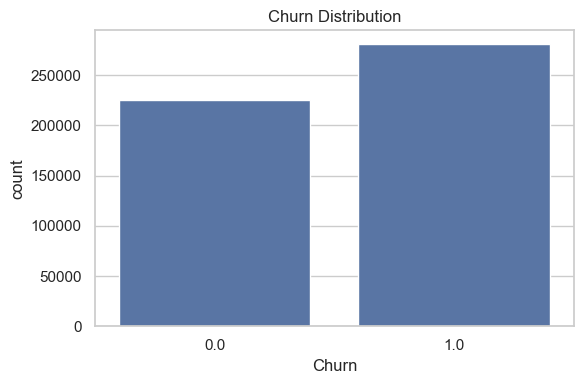

In [72]:
# ----- 6. Churn distribution -----

if 'Churn' in df.columns:
    churn_counts = df['Churn'].value_counts()
    churn_pct = df['Churn'].value_counts(normalize=True)
    print(f"\nChurn class distribution:\n----------\n{churn_counts}\n----------\nProportional:\n----------\n{churn_pct}")

    # Grafik: Churn count
    os.makedirs('reports/figs', exist_ok=True)
    plt.figure(figsize=(6,4))
    sns.countplot(x='Churn', data=df)
    plt.title('Churn Distribution')
    plt.tight_layout()

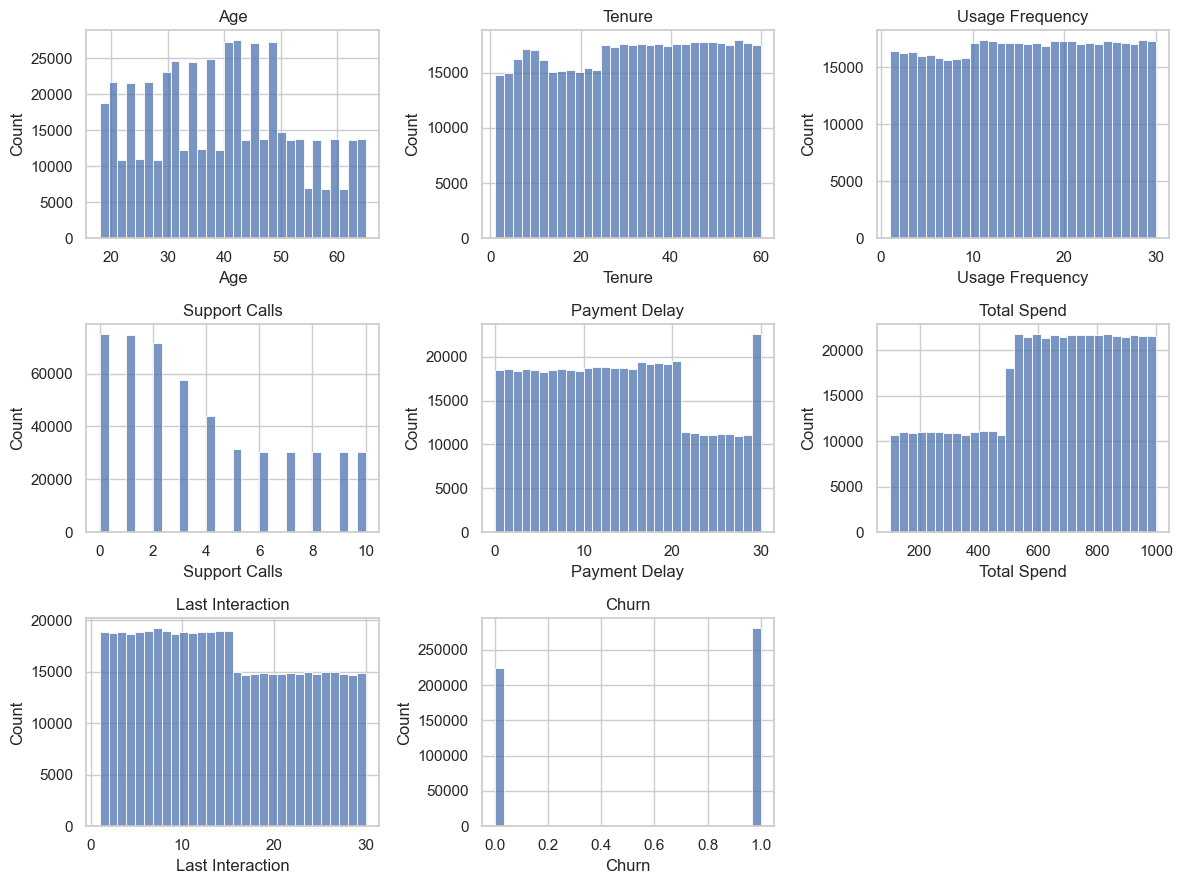

In [73]:
# ----- 7. Distribution of numerical data (histogram) -----
num_for_plot = [c for c in num_cols if c != 'customerID']
if len(num_for_plot) > 0:
    n = len(num_for_plot)
    cols = 3
nrows = int(np.ceil(n/cols)) if len(num_for_plot)>0 else 0
if nrows > 0:
    plt.figure(figsize=(cols*4, nrows*3))
    for i, col in enumerate(num_for_plot, 1):
        plt.subplot(nrows, cols, i)
        sns.histplot(df[col].dropna(), kde=False, bins=30)
        plt.title(col)
    plt.tight_layout()

Before plotting the correlation matrix, we need to convert string values to numerical data, since correlation matrix will show the relationship between features only with numerical data.

In [74]:
# ----- 8. Convert string classes into numerical data -----

le = LabelEncoder()
for col in df.select_dtypes(include='object'):
    df[col] = le.fit_transform(df[col])

# Check numerical classes
print('\n')
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumerical features ({len(num_cols)}): {num_cols}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols}")

print('\n--- Numerical features and unique values ---')
for n in num_cols:
    uniques = df[n].unique()
    print(f"\n{n}: Number of unique values ={len(uniques)} {list(uniques[:5])}")




Numerical features (12): ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']
Categorical features (0): []

--- Numerical features and unique values ---

CustomerID: Number of unique values =442211 [2.0, 3.0, 4.0, 5.0, 6.0]

Age: Number of unique values =48 [30.0, 65.0, 55.0, 58.0, 23.0]

Gender: Number of unique values =2 [0, 1]

Tenure: Number of unique values =60 [39.0, 49.0, 14.0, 38.0, 32.0]

Usage Frequency: Number of unique values =30 [14.0, 1.0, 4.0, 21.0, 20.0]

Support Calls: Number of unique values =11 [5.0, 10.0, 6.0, 7.0, 9.0]

Payment Delay: Number of unique values =31 [18.0, 8.0, 7.0, 26.0, 16.0]

Subscription Type: Number of unique values =3 [2, 0, 1]

Contract Length: Number of unique values =3 [0, 1, 2]

Total Spend: Number of unique values =68363 [932.0, 557.0, 185.0, 396.0, 617.0]

Last Interaction: Number of unique values =30 [17.0, 6.0, 

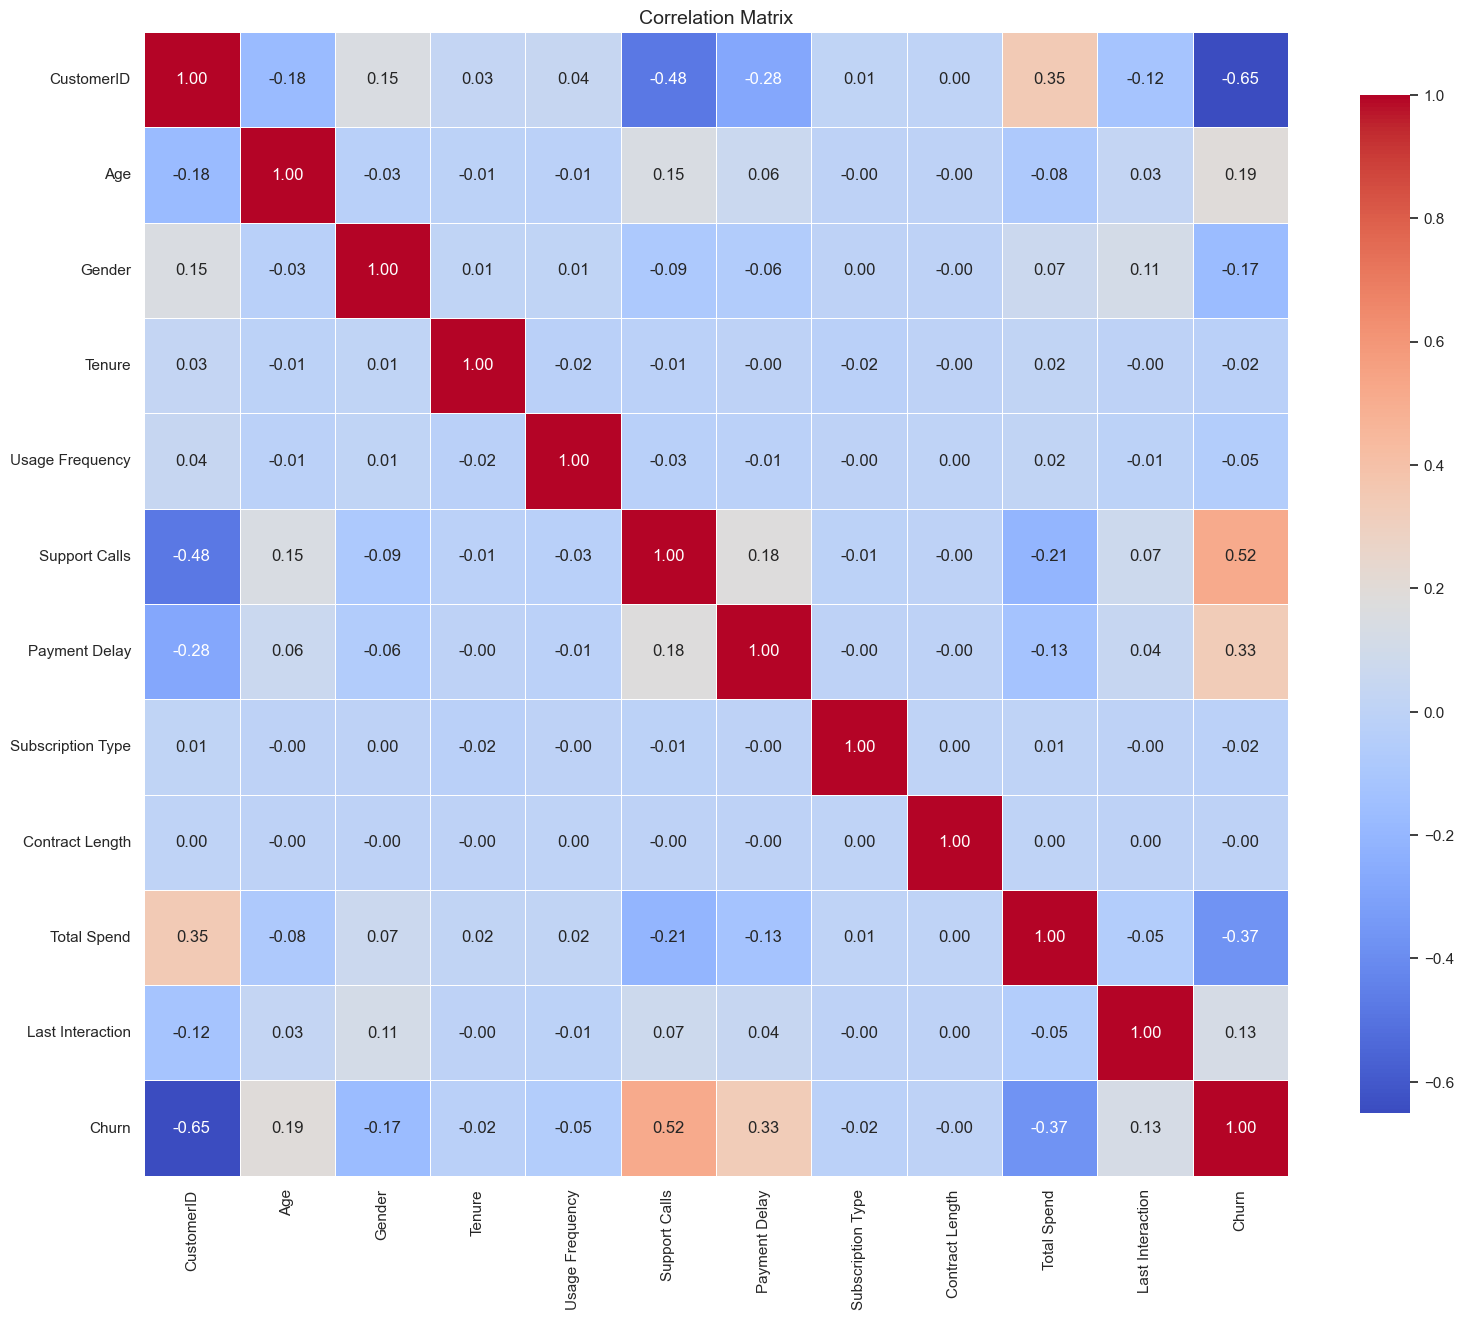

In [75]:
# ----- 9. Correlation Matrix -----

plt.figure(figsize=(16, 14))

# Correlation between only numerical features can be calculated
corr = df.corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

In [76]:
# ----- 10. Drop features that have correlation lower than 0.15 with the target (churn) -----

low_corr = []

for col in df.columns:
    if col != 'Churn' and col != 'source':
        corr = df['Churn'].corr(df[col])
        if abs(corr) < 0.1:
            low_corr.append(col)

print('Features with correlation lower than 0.15 with the target (Churn):')
print(low_corr)

df.drop(low_corr, axis=1, inplace=True)
df.drop('CustomerID', axis = 1, inplace = True)

df.head(3)

Features with correlation lower than 0.15 with the target (Churn):
['Tenure', 'Usage Frequency', 'Subscription Type', 'Contract Length']


,Age,Gender,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
0,30.0,0,5.0,18.0,932.0,17.0,1.0
1,65.0,0,10.0,8.0,557.0,6.0,1.0
2,55.0,0,6.0,18.0,185.0,3.0,1.0


### **MACHINE LEARNING ALGORITHMS**

In [92]:
# Import necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from xgboost import XGBClassifier

In [78]:
# Define features as input and target (X, y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the minority class with SMOTE method
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### **1. LOGISTIC REGRESSION**

In [81]:
# Create the pipeline (Scaling and model)
lr_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['lbfgs', 'liblinear']
}
grid_search = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Build optimized model
best_lr = grid_search.best_estimator_

# Predictions and probability
y_proba_lr = best_lr.predict_proba(X_test)[:,1]

# Specify the threshold for classification
threshold = 0.5
y_pred_lr = (y_proba_lr > threshold).astype(int)

# Performance metrics
accuracy_lr = round(accuracy_score(y_test, y_pred_lr),3)
f1_score_lr = round(f1_score(y_test, y_pred_lr),3)
roc_auc_lr = round(roc_auc_score(y_test, y_proba_lr),3)
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr), index=['Actual 0','Actual 1'], columns=['Pred 0','Pred 1'])
#cm_df_lr = pd.DataFrame(cm_lr, index=['Actual 0','Actual 1'], columns=['Pred 0','Pred 1'])
print("\nLogistic Regression Confusion Matrix:\n", cm_lr)


Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.84      0.80     44943
         1.0       0.86      0.79      0.83     56099

    accuracy                           0.82    101042
   macro avg       0.81      0.82      0.81    101042
weighted avg       0.82      0.82      0.82    101042


Logistic Regression Confusion Matrix:
           Pred 0  Pred 1
Actual 0   37972    6971
Actual 1   11713   44386


### **2. EXTREME GRADIENT BOOSTING (XGB)**

In [104]:
# Build the model of XG-Boost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_pipeline = Pipeline(steps=[('classifier', xgb_model)])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 1],
    'classifier__colsample_bytree': [0.7, 1]
}

grid_search_xgb = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search_xgb.fit(X_train_res, y_train_res)

best_xgb = grid_search_xgb.best_estimator_

# Predictions and probability
y_proba_xgb = best_xgb.predict_proba(X_test)[:,1]

# Specify the threshold for classification
threshold = 0.3
y_pred_xgb = (y_proba_xgb > threshold).astype(int)

# Performance metrics
accuracy_xgb = round(accuracy_score(y_test, y_pred_xgb),3)
f1_score_xgb = round(f1_score(y_test, y_pred_xgb),3)
roc_auc_xgb = round(roc_auc_score(y_test, y_proba_xgb),3)
print("\nXG-Boost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb), index=['Actual 0','Actual 1'], columns=['Pred 0','Pred 1'])
print("\nXG-Boost Classifier Confusion Matrix:\n", cm_xgb)


XG-Boost Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     44943
         1.0       0.90      0.97      0.94     56099

    accuracy                           0.93    101042
   macro avg       0.93      0.92      0.92    101042
weighted avg       0.93      0.93      0.92    101042


XG-Boost Classifier Confusion Matrix:
           Pred 0  Pred 1
Actual 0   38811    6132
Actual 1    1431   54668


### **3. LIGHT GRADIENT BOOSTING MACHINE (LGBM)**

In [106]:
# Build the model for LGBM
lgbm = LGBMClassifier(random_state=42)

# Hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}
random_lgb = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42
)
random_lgb.fit(X_train_res, y_train_res)
best_lgb = random_lgb.best_estimator_

# Probability and predictions
y_pred_lgb = best_lgb.predict(X_test)
y_proba_lgb = best_lgb.predict_proba(X_test)[:,1]

# Performance metrics
accuracy_lgb = round(accuracy_score(y_test, y_pred_lgb),3)
f1_score_lgb = round(f1_score(y_test, y_pred_lgb),3)
roc_auc_lgb = round(roc_auc_score(y_test, y_proba_lgb),3)
print("\nLight-GBM Classification Report:\n", classification_report(y_test, y_pred_lgb))

# Confusion Matrix
cm_lgb = pd.DataFrame(confusion_matrix(y_test, y_pred_lgb), index=['Actual 0','Actual 1'], columns=['Pred 0','Pred 1'])
print("\nLight-GBM Classifier Confusion Matrix:\n", cm_lgb)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 224393, number of negative: 224393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 448786, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Light-GBM Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     44943
         1.0       0.90      0.97      0.94     56099

    accuracy                           0.93    101042
   macro avg       0.93      0.92      0.92    101042
weighted avg       0.93      0.93      0.92    101042


Light-GBM Classifier Confusion Matrix:
           Pred 0  Pred 1
Actual 0   38812    6131
Actual 1    1435   54664


### **RESULTS & MODEL COMPARISON**

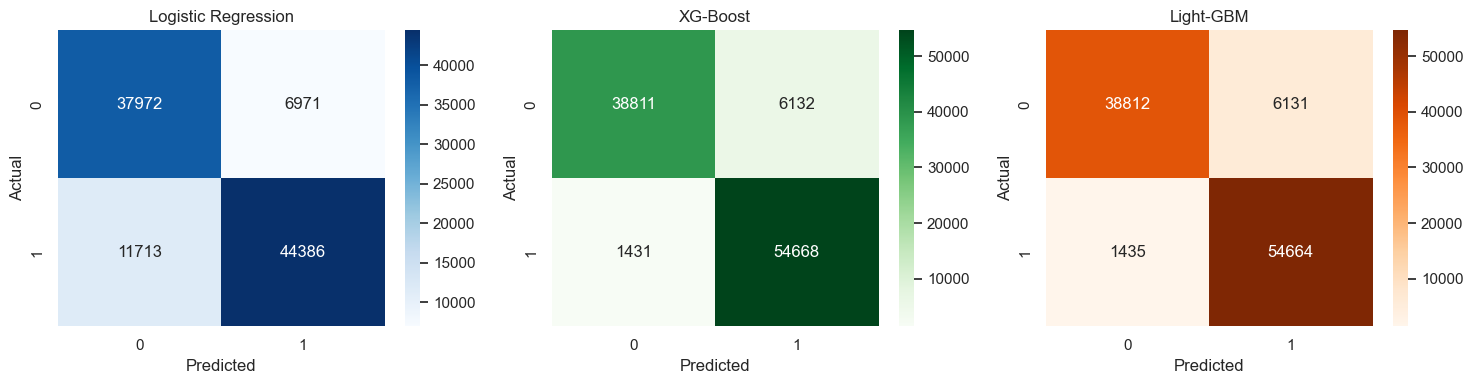

In [107]:
# ----- Confusion Matrix Comparison -----

cm_list = [cm_lr.values, cm_xgb.values, cm_lgb.values]
model_names = ['Logistic Regression', 'XG-Boost', 'Light-GBM']

cmaps = ['Blues', 'Greens', 'Oranges']

fig, axes = plt.subplots(1, 3, figsize=(15,4))

for i, ax in enumerate(axes):
    sns.heatmap(cm_list[i], annot=True, fmt='d', cmap=cmaps[i], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(model_names[i])

plt.tight_layout()
plt.show()

                 Model  Accuracy  F1 Score  ROC-AUC
0  Logistic Regression     0.815     0.826    0.887
1             XG-Boost     0.925     0.935    0.938
2            Light-GBM     0.925     0.935    0.938


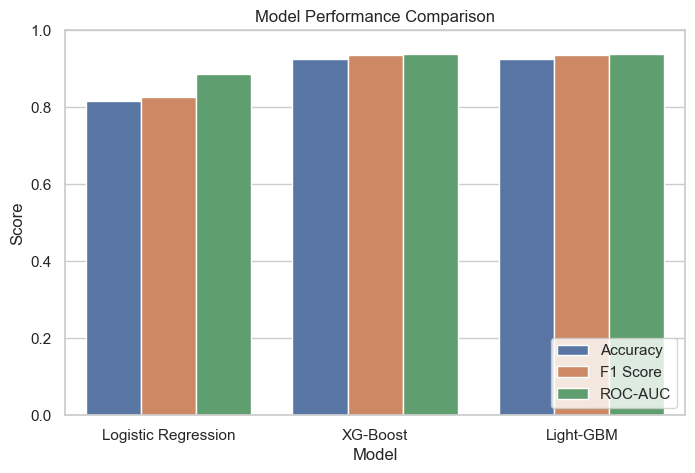

In [108]:
# ----- Performance Metrics Comparison -----

metrics = {
    'Model': ['Logistic Regression', 'XG-Boost', 'Light-GBM'],
    'Accuracy': [accuracy_lr, accuracy_xgb, accuracy_lgb],
    'F1 Score': [f1_score_lr, f1_score_xgb, f1_score_lgb],
    'ROC-AUC': [roc_auc_lr, roc_auc_xgb, roc_auc_lgb]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

df_plot = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(8,5))
sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

### Overall Performance Metrics

| Model               | Accuracy  | F1 Score  | ROC-AUC   |
| ------------------- | --------- | --------- | --------- |
| Logistic Regression | 0.815     | 0.826     | 0.887     |
| XGBoost             | **0.925** | **0.935** | **0.938** |
| LightGBM            | **0.925** | **0.935** | **0.938** |

Both **XGBoost** and **LightGBM** significantly outperform **Logistic Regression** across all evaluated metrics. The boosting-based algorithms exhibit superior capability in capturing complex non-linear dependencies within the dataset, resulting in higher predictive accuracy and robustness. The performance similarity between XGBoost and LightGBM suggests that both frameworks are equally suitable for this classification problem. In contrast, Logistic Regression’s linear nature limits its ability to model non-linear feature interactions, leading to relatively lower performance.

---

### Confusion Matrix Analysis

| Model               | True Negative (TN) | False Positive (FP) | False Negative (FN) | True Positive (TP) |
| ------------------- | ------------------ | ------------------- | ------------------- | ------------------ |
| Logistic Regression | 37,972             | 6,971               | 11,713              | 44,386             |
| XGBoost             | 38,811             | 6,132               | 1,431               | 54,668             |
| LightGBM            | 38,812             | 6,131               | 1,435               | 54,664             |

The confusion matrices further confirm the superiority of the boosting models. **XGBoost** and **LightGBM** both achieve a substantial reduction in false negatives compared to Logistic Regression. This implies that these models are far more effective in identifying churners (positive class). Specifically, while Logistic Regression misclassifies over **11,700 churners** as non-churners, both boosting models reduce this number to approximately **1,400**. The number of false positives remains relatively consistent across models, indicating that the gains in recall do not come at the expense of precision.

---

### Interpretation

The results highlight the strong generalization ability of ensemble boosting methods in handling complex feature interactions and class imbalance. Both XGBoost and LightGBM achieve **ROC-AUC scores above 0.93**, reflecting excellent discriminative performance between churn and non-churn classes. Additionally, their **F1 scores around 0.935** demonstrate a balanced trade-off between precision and recall—an essential characteristic for imbalanced datasets where both false negatives and false positives have business implications.

---

### Conclusion

In conclusion, **XGBoost** and **LightGBM** provide superior predictive performance compared to **Logistic Regression**. Their comparable results indicate that either algorithm could be effectively deployed for churn prediction in this context. Given their scalability, interpretability through feature importance analysis, and high classification accuracy, these models represent the most reliable candidates for production implementation. Logistic Regression, while interpretable and computationally efficient, lacks the modeling capacity required for this specific problem’s complexity.

---
